## Visualize similarities between synthetic and actual datasets using SOMs

A self-organizing map (SOM) or self-organizing feature map (SOFM) is a type of artificial neural network (ANN) that is trained in an unsupervised way to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples, called a map.

**Objective:**
In this notebook we use 2-d feature map generated by SOM to visualize the closeness of samples generated using GANs with that of the actual dataset. The true power of SOMs are unleashed here by enabling us to visualise a multidimensional dataset (36 features) on a 2d map.


In [76]:
# Load the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ctgan import CTGANSynthesizer
from minisom import MiniSom

In [77]:
# Load data
test = pd.read_csv('data/porto_seguro_safe_driver/test.csv') # to test the predictions in the test set, install Kaggle API and run it on the competition kernel
train = pd.read_csv('data/porto_seguro_safe_driver/train.csv')

In [78]:
# Handle missing values

def filling_missing_values(data):
    '''A function to fill in the missing values of categorical features'''
    for i in data.columns.values:
        if data.isnull().values.any():
            if i == 'ps_car_03_cat' or i == 'ps_car_05_cat':
                continue
            elif i == 'ps_ind_05_cat' or i == 'ps_car_07_cat':
                data[i].fillna(data[i].mode()[0], inplace=True)
            else:
                data[i].fillna(data[i].mean(), inplace=True)
        else:
            continue
    return data


# Determine missing values in each column of the given dataframe
def missing_values(data):
    '''Function to find the percentage of missing values in each column of a DataFrame passed'''
    for i in data.columns.values:
        count =  data[data[i] == -1].shape[0]
        print("Missing Values in '{}' : {:.4f} %".format(i, (count/data.shape[0])*100))
        

train = train.replace(-1, np.nan)
train = train.replace(-1, np.nan)
        
# Fill missing values in train and test        
train = filling_missing_values(train)
test = filling_missing_values(test)       

# Check for missing values after filling
# missing_values(train)
# missing_values(test)

# Drop columns that are not needed
col_to_drop = list(train.columns[train.columns.str.startswith('ps_calc_')])
# Drop columns that are missing a lot as values
col_to_drop += ['ps_car_03_cat', 'ps_car_05_cat']
train = train.drop(col_to_drop, axis=1)  
test = test.drop(col_to_drop, axis=1)

# Drivers who didn't claim insurance
df_no_insurance_claim = train.loc[train.target==0].copy()
df_no_insurance_claim['target'] = 2
df_no_insurance_claim = df_no_insurance_claim.drop(['id'], axis=1)
# Get only 10000 samples for visualization
df_no_insurance_claim = df_no_insurance_claim.iloc[:10000,:]

In [15]:
# Generate data using GANs to handle class imbalance

# Preprocess data for GAN sampling

train_gen = train.loc[train.target==1, train.columns != 'target'].copy()
train_gen = train_gen.drop(['id'], axis=1)

# List of categorical features
cat_features = [a for a in train_gen.columns if a.endswith('cat')]

ctgan = CTGANSynthesizer()
ctgan.fit(train_gen, cat_features, epochs=5)

# Add identifier to train data
train_gen['target'] = 0

Epoch 1, Loss G: 1.5195, Loss D: -0.2885
Epoch 2, Loss G: 0.2125, Loss D: 0.2990
Epoch 3, Loss G: 0.5012, Loss D: -0.1451
Epoch 4, Loss G: -0.2318, Loss D: 0.4568
Epoch 5, Loss G: -0.6203, Loss D: 0.4237


In [28]:
# adding 5000 samples to train dataset
samples = ctgan.sample(5000)
samples['target'] = 1
print(samples.shape)
samples.head()

(5000, 36)


,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
0,7.391686,1.0,6.062301,0.0,0.0,-0.009447,0.995261,-0.003841,1.040840,0.001656,...,1.0,2.0,1.0,18.0,-0.102241,0.392623,0.812738,0.371892,3.611457,1
1,0.089024,1.0,4.043444,0.0,4.0,0.001840,-0.003700,0.000880,-0.000319,-0.000505,...,1.0,2.0,1.0,26.0,-0.171723,0.405419,0.580743,0.388303,3.139206,1
2,2.086413,1.0,4.061213,0.0,0.0,0.000897,0.001479,0.001063,1.034170,0.002500,...,1.0,2.0,1.0,32.0,3.002174,0.373821,0.616073,0.325253,3.722024,1
3,0.108719,2.0,8.704949,1.0,0.0,-0.005793,0.005373,0.978790,0.003985,0.001562,...,1.0,0.0,1.0,64.0,2.978727,0.445545,1.062549,0.460992,2.690449,1
4,1.083085,1.0,10.143953,0.0,0.0,0.000465,0.009051,-0.005865,0.007779,0.002475,...,1.0,2.0,1.0,104.0,0.028633,0.444560,1.672427,0.609222,3.751237,1


In [86]:
# Append to train data
total_set = pd.concat([train_gen, samples, df_no_insurance_claim], axis=0, sort=True)

# Data preprocessing for Self organizing Map

# Function to encode categorical columns
def one_hot_encoding(df):
    cat_features = [a for a in df.columns if a.endswith('cat')]

    for column in cat_features:
        temp = pd.get_dummies(pd.Series(df[column]))
        df = pd.concat([df,temp],axis=1)
        df = df.drop([column],axis=1)
    return df

total_coded = one_hot_encoding(total_set.loc[:, total_set.columns != 'target'])

print(total_set.values.shape, total_coded.values.shape)


(36694, 36) (36694, 198)


In [63]:
# Convert to numpy arrays
X = total_coded[total_set['target']!=2].values
y = total_set[total_set['target']!=2]['target'].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [65]:
# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 20, y = 20, input_len = 199, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

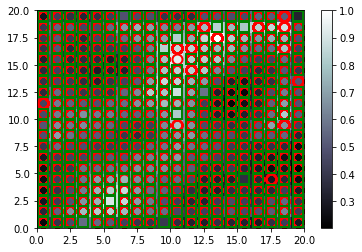

In [66]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

**Red** : Drivers who claimed for insurance

**Green**: Drivers sampled from those who claimed for insurance



Inference: The above map plots the actual drivers who claimed for insurance and the ones that were sampled using GANs.
* Both these groups are homogenously distributed across the entire map and almost all the neurons (except a few) have both the actual and the sampled drivers. This illustrates that this GAN is able to synthesize across the entire spectrum.

* As seen from the map below the neurons with high inter neuron distances (0.9 -1) are outliers and are expected to be different from the majority.

* As we can see the neurons with high inter neuron distances (outliers) are mostly filled with only the actual drivers and not the sampled ones. This suggests that GANs are able to successfully eliminate outliers while synthesizing data. 

* This visualization can also be used to remove/ refine sampling by separating outlier nodes represented only by the sampled drivers 

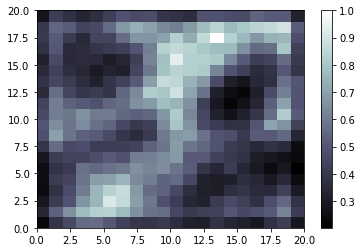

In [68]:
# Legend on the right specifies mean inter neuron distance
bone()
pcolor(som.distance_map().T)
colorbar()

#### Running SOM on all three target classes - 1. Drivers who didn't claim insurance 2. Drivers who claimed insurance 3. Sampled drivers from drivers who claimed insurance,  to see the distribution

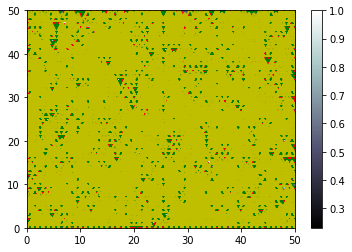

In [89]:
# Convert to numpy arrays
X = total_coded.values
y = total_set['target'].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 50, y = 50, input_len = 198, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 150)

# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's', '^']
colors = ['r', 'g', 'y']
markersize = [5, 10, 8]
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = markersize[y[i]],
         markeredgewidth = 2)
show()

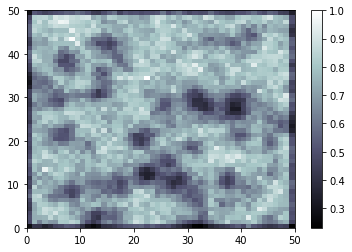

In [90]:
bone()
pcolor(som.distance_map().T)
colorbar()

**Red**: Drivers who claimed for insurance

**Green**: Drivers sampled from those who claimed for insurance

**Yellow**: Drivers without insurance claims

**Inference**
* Red & Green groups seem to be clustered together mostly. This is a measure of how good the sampling was
* The heat map above shows clustered regions that have neurons that are close together (~ 0-0.5 inter neuron distance) and by visually comparing it to the marked plot (showing red/yellow/green) we can quickly identify regions that correspond to drivers who have claimed for insurance (both actual & sampled)